In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize data to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten the images
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Hypermodel

In [3]:
def build_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_1', values=['relu', 'tanh']),
        input_dim=28 * 28
    ))

    # Optional Dropout layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_2', values=['relu', 'tanh'])
    ))

    # Optional Dropout layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Set Up Keras Tuner

In [4]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,                # Model-building function
    objective='val_accuracy',   # Optimization objective
    max_trials=10,              # Number of hyperparameter combinations to try
    executions_per_trial=2,     # Number of models to train per combination
    directory='hyperparam_tuning',  # Directory to save results
    project_name='mnist_tuning'     # Name of the tuning project
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Run the Tuning Process

In [5]:
# Start the hyperparameter search
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first layer is {best_hps.get('units_1')},
the activation function is {best_hps.get('activation_1')},
and the optimizer is {best_hps.get('optimizer')}.
""")

Trial 10 Complete [00h 01m 31s]
val_accuracy: 0.9282083213329315

Best val_accuracy So Far: 0.9802083373069763
Total elapsed time: 00h 15m 47s

The optimal number of units in the first layer is 384,
the activation function is relu,
and the optimizer is rmsprop.



## Build and Train the Best Model

In [6]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    verbose=1
)

# Evaluate on test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8444 - loss: 0.5084 - val_accuracy: 0.9583 - val_loss: 0.1386
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9638 - loss: 0.1207 - val_accuracy: 0.9701 - val_loss: 0.0969
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9775 - loss: 0.0738 - val_accuracy: 0.9742 - val_loss: 0.0880
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9828 - loss: 0.0519 - val_accuracy: 0.9742 - val_loss: 0.0871
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9880 - loss: 0.0387 - val_accuracy: 0.9772 - val_loss: 0.0816
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9902 - loss: 0.0309 - val_accuracy: 0.9771 - val_loss: 0.0809
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9929 - loss: 0.0216 - val_accuracy: 0.9783 - val_loss: 0.0862
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9936 - loss: 0.0188 - val_accu

## Visualize Training Performance

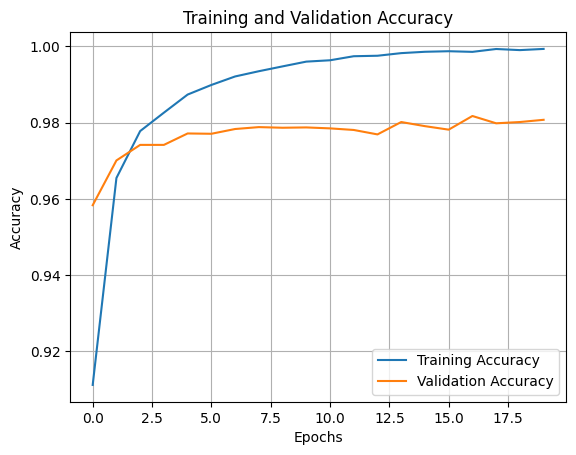

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()